<a href="https://colab.research.google.com/github/ZohrehAdabi/MAML/blob/weight-analysis/norm_of_weights_maml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAML reimplementation using TensorFlow 2.0

Reproduction of MAML using TensorFlow 2.0.

This  is highly influenced by the pytorch reproduction by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### TensorFlow installation

In [1]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 46kB/s 
     |████████████████████████████████| 3.0MB 44.1MB/s 
     |████████████████████████████████| 419kB 66.7MB/s 


### Imports

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend


# Other dependencies
import random
import sys
import time
import datetime

%load_ext tensorboard.notebook

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib as mpl
mpl.style.use('seaborn')
# from colorama import Fore
# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

Python version:  3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
TensorFlow version:  2.0.0-alpha0
GPU found at: /device:GPU:0


## Section 5.1 Evaluating MAML on regression

> *We start with a simple regression problem that illustrates
the basic principles of MAML. Each task involves regressing
from the input to the output of a sine wave, where the
amplitude and phase of the sinusoid are varied between
tasks. Thus, p(T ) is continuous, where the amplitude
varies within [0.1, 5.0] and the phase varies within [0, π],
and the input and output both have a dimensionality of 1.
During training and testing, datapoints x are sampled uniformly
from [−5.0, 5.0].*

![]()

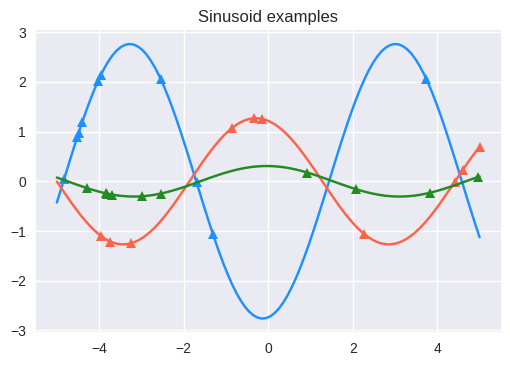

In [3]:
class SinusoidGenerator():
    '''
        Sinusoid Generator.
        
        p(T) is continuous, where the amplitude varies within [0.1, 5.0]
        and the phase varies within [0, π].
        
        This abstraction is the basically the same defined at:
        https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0  
    '''
    def __init__(self, K=10, amplitude=None, phase=None):
        '''
        Args:
            K: batch size. Number of values sampled at every batch.
            amplitude: Sine wave amplitude. If None is uniformly sampled from
                the [0.1, 5.0] interval.
            pahse: Sine wave phase. If None is uniformly sampled from the [0, π]
                interval.
        '''
        self.K = K
        self.amplitude = amplitude if amplitude else np.random.uniform(0.1, 5.0)
        self.phase = phase if amplitude else np.random.uniform(-np.pi, np.pi)
        self.sampled_points = None
        self.x = self._sample_x()
        
    def _sample_x(self):
        return np.random.uniform(-5, 5, self.K)
    
    def f(self, x):
        '''Sinewave function.'''
        return self.amplitude * np.sin(x - self.phase)

    def batch(self, x = None, force_new=False):
        '''Returns a batch of size K.
        
        It also changes the shape of `x` to add a batch dimension to it.
        
        Args:
            x: Batch data, if given `y` is generated based on this data.
                Usually it is None. If None `self.x` is used.
            force_new: Instead of using `x` argument the batch data is
                uniformly sampled.
        
        '''
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x)
        return x[:, None], y[:, None]
    
    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(x=np.linspace(-5, 5, K))
        
        
def plot(data,color, *args, **kwargs):
    '''Plot helper.'''
    x, y = data.batch()
    ax.plot(x, y,'^', color=color)
    x, y = data.equally_spaced_samples(100)
    return ax.plot(x, y, color=color)

fig = plt.figure(figsize=(6,4), dpi=100)
ax = fig.add_subplot(111)
ax.set_title('Sinusoid examples')
colors = {0:'dodgerblue' , 1: 'tomato' , 2:'forestgreen'}
for i in range(3):

    plot(SinusoidGenerator(K=10),colors[i])
plt.show()

### Generate sinusoid datasets


In [4]:
def generate_dataset(K, train_size=20000, test_size=10):
    '''Generate train and test dataset.
    
    A dataset is composed of SinusoidGenerators that are able to provide
    a batch (`K`) elements at a time.
    '''
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size) 

train_ds, test_ds = generate_dataset(K=10, test_size=25)
train_ds[0]

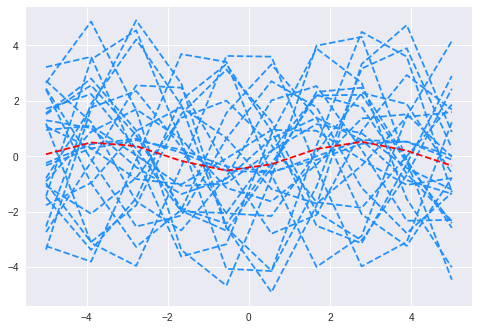

In [5]:
ts_ds = test_ds
# tr_ds, ts_ds = generate_dataset(K=10, test_size=25)
avg_pred =[]
x, _ = SinusoidGenerator(K=10).equally_spaced_samples()  
for i, sinusoid_generator in enumerate(ts_ds):
        _ , y = sinusoid_generator.equally_spaced_samples()
        plt.plot(x, y,'--',color=colors[0])
        avg_pred.append(y)
avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0),'--',color='red')
plt.show()

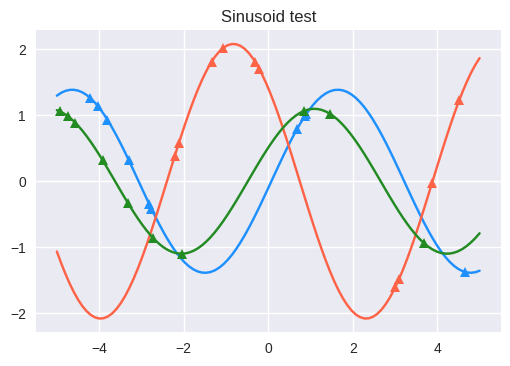

In [6]:
fig = plt.figure(figsize=(6,4), dpi=100)
ax = fig.add_subplot(111)
ax.set_title('Sinusoid test')

for i in range(3):

    plot(test_ds[i],color=colors[i])
plt.show()

### Training a regular Neural Network

We're training a Neural Network for given a batch of size *K* of randomly sampled values (*x*) predict *f(x)* where f is a sine wave function with amplitude randomly sampled within [0.1, 5.0] and the phase randomly sampled within [0, π].

#### Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [0]:
class SineModel(keras.Model):

    def __init__(self):
        super().__init__()
        # super(SineModel, self).__init__()

        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
      

    # @tf.function      
    def call(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        
        x = self.out(x)
        return x

#### Training implementation

In [0]:
def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.call(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss


def train_model(dataset, epochs=1, lr=0.01, log_steps=1000):
    model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
   
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, sinusoid_generator in enumerate(dataset):

            x, y = sinusoid_generator.batch()
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            # tf.summary.trace_on(graph=True, profiler=True)
            with train_summary_writer.as_default():
                tf.summary.scalar('loss', curr_loss, step=i)
                # tf.summary.trace_export( name="my_func_trace", step=i, profiler_outdir=train_log_dir)
                # tf.summary.histogram('H1', model.hidden1.get_weights)
         
            
            if i % log_steps == 0 and i >= 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        fig = plt.figure(figsize=(12, 5), tight_layout=True)
        ax = fig.add_subplot(1,1,1)
        ax.plot(losses)
        ax.set_title('Loss Vs Time steps')
        plt.show()
        print(losses)
    return model

### Plot

Model: "sine_model_20024"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60072 (Dense)          multiple                  80        
_________________________________________________________________
dense_60073 (Dense)          multiple                  1640      
_________________________________________________________________
dense_60074 (Dense)          multiple                  41        
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________
None


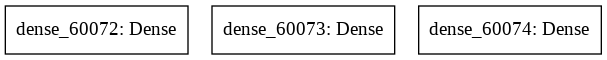

In [41]:
from keras.utils.vis_utils import plot_model
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model = SineModel()
model.build(input_shape=(1,1))
print(model.summary())
plot_model(model)

In [0]:
# !rm -rf ./logs/ #remove previous log

In [0]:

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


#### Train Model

Step 0: loss = 0.9233266799291892, Time to run 1000 steps = 1.29 seconds
Step 1000: loss = 4.116208742542823, Time to run 1000 steps = 9.14 seconds
Step 2000: loss = 4.169220125137713, Time to run 1000 steps = 8.86 seconds
Step 3000: loss = 4.169354732747397, Time to run 1000 steps = 8.90 seconds
Step 4000: loss = 4.1655218602865824, Time to run 1000 steps = 8.65 seconds
Step 5000: loss = 4.179645846347676, Time to run 1000 steps = 8.78 seconds
Step 6000: loss = 4.197273266777939, Time to run 1000 steps = 9.03 seconds
Step 7000: loss = 4.19399697403305, Time to run 1000 steps = 8.80 seconds
Step 8000: loss = 4.2070319185794585, Time to run 1000 steps = 9.05 seconds
Step 9000: loss = 4.212557649033335, Time to run 1000 steps = 8.69 seconds
Step 10000: loss = 4.2151499054268395, Time to run 1000 steps = 8.94 seconds
Step 11000: loss = 4.226262355697265, Time to run 1000 steps = 8.66 seconds
Step 12000: loss = 4.234951960313611, Time to run 1000 steps = 9.07 seconds
Step 13000: loss = 4.2

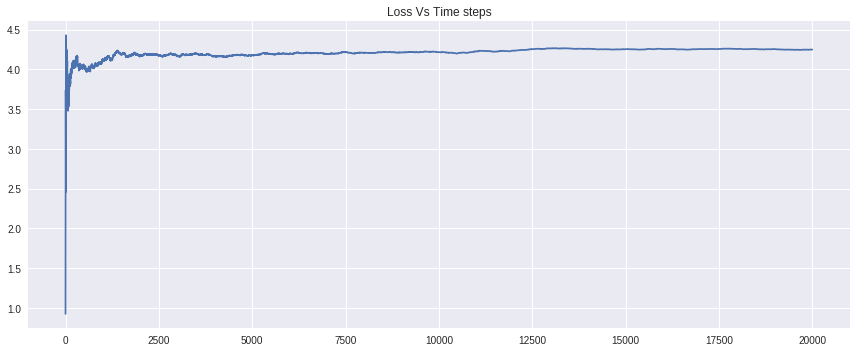

[<tf.Tensor: id=475, shape=(), dtype=float64, numpy=0.9233266799291892>, <tf.Tensor: id=635, shape=(), dtype=float64, numpy=1.7167995953813542>, <tf.Tensor: id=794, shape=(), dtype=float64, numpy=2.0798716411512257>, <tf.Tensor: id=953, shape=(), dtype=float64, numpy=1.6410412874158788>, <tf.Tensor: id=1112, shape=(), dtype=float64, numpy=3.7368354103595536>, <tf.Tensor: id=1271, shape=(), dtype=float64, numpy=3.146387066342063>, <tf.Tensor: id=1430, shape=(), dtype=float64, numpy=3.560972352416632>, <tf.Tensor: id=1589, shape=(), dtype=float64, numpy=3.3161335137312427>, <tf.Tensor: id=1748, shape=(), dtype=float64, numpy=2.967818480766706>, <tf.Tensor: id=1907, shape=(), dtype=float64, numpy=2.692786162639322>, <tf.Tensor: id=2066, shape=(), dtype=float64, numpy=2.458207257822783>, <tf.Tensor: id=2225, shape=(), dtype=float64, numpy=3.140234265744947>, <tf.Tensor: id=2384, shape=(), dtype=float64, numpy=3.242002260457802>, <tf.Tensor: id=2543, shape=(), dtype=float64, numpy=3.2379728

In [11]:
neural_net = train_model(train_ds)

In [0]:
# %tensorboard --logdir logs/gradient_tape

A neural network trained for this task, should converge to the average of the sinusoids curves.

In [0]:
def plot_model_comparison_to_average(model, ds, model_name='neural network', K=10):
    '''Compare model to average.
    
    Computes mean of training sine waves actual `y` and compare to
    the model's prediction to a new sine wave, the intuition is that
    these two plots should be similar.
    '''
    sinu_generator = SinusoidGenerator(K=K)
    
    # calculate average prediction
    avg_pred = []
    for i, sinusoid_generator in enumerate(ds):
        _ , y = sinusoid_generator.equally_spaced_samples()
        avg_pred.append(y)
    
    x, _ = sinu_generator.equally_spaced_samples()    
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0),'--',color=colors[2])

    # calculate model prediction
    model_pred = model.call(tf.convert_to_tensor(x))
    model_plot, = plt.plot(x, model_pred.numpy(), color=colors[0])
    
    # plot
    plt.legend([avg_plot, model_plot], ['Average', model_name])
    plt.show()

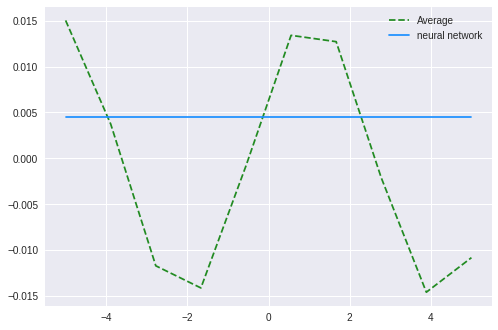

In [13]:
plot_model_comparison_to_average(neural_net, train_ds)

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

In [0]:
def copy_model(model, x):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = SineModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.call(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model


def eval_sine_test(model, optimizer, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    '''Evaluate how the model fits to the curve training for `fits` steps.
    
    Args:
        model: Model evaluated.
        optimizer: Optimizer to be for training.
        x: Data used for training.
        y: Targets used for training.
        x_test: Data used for evaluation.
        y_test: Targets used for evaluation.
        num_steps: Number of steps to log.
    '''
    fit_res = []
    
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    
    # If 0 in fits we log the loss before any training
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step, 
                    logits,
                    loss
                )
            )
    return fit_res


def eval_sinewave_for_test(model, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01, plot=True):
    '''Evaluates how the sinewave addapts at dataset.
    
    The idea is to use the pretrained model as a weight initializer and
    try to fit the model on this new dataset.
    
    Args:
        model: Already trained model.
        sinusoid_generator: A sinusoidGenerator instance.
        num_steps: Number of training steps to be logged.
        lr: Learning rate used for training on the test data.
        plot: If plot is True than it plots how the curves are fitted along
            `num_steps`.
    
    Returns:
        The fit results. A list containing the loss, logits and step. For
        every step at `num_steps`.
    '''
    
    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)
        
    # generate equally spaced samples for ploting
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)
    
    # batch used for training
    x, y = sinusoid_generator.batch()
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x)
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)
    
    # plot
    fig = plt.figure(figsize=(12, 5), tight_layout=True)
    ax = fig.add_subplot(1,1,1)
    train, = ax.plot(x, y, '^')
    ground_truth, = ax.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    i = 0
    for n, res, loss in fit_res:
        cur, = ax.plot(x_test, res[:, 0], '--', color=colors[i] )
        plots.append(cur)
        legend.append(f'After {n} Steps')
        i +=1%3
    ax.legend(plots, legend)
    ax.set_ylim(-5, 5)
    ax.set_xlim(-6, 6)
    if plot:
        plt.show()
    
    return fit_res

### Try to use transfer learning for different sine waves

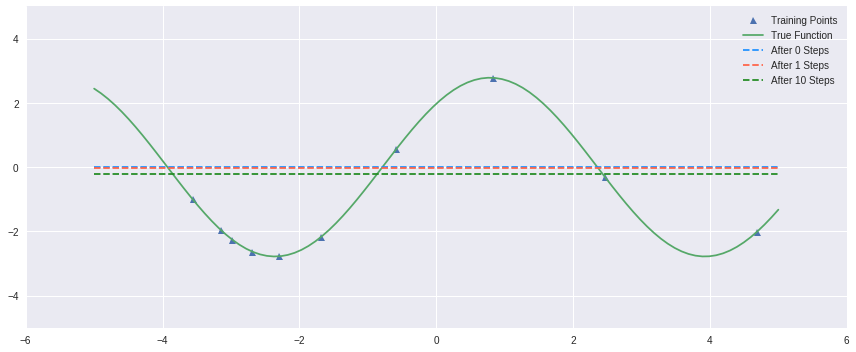

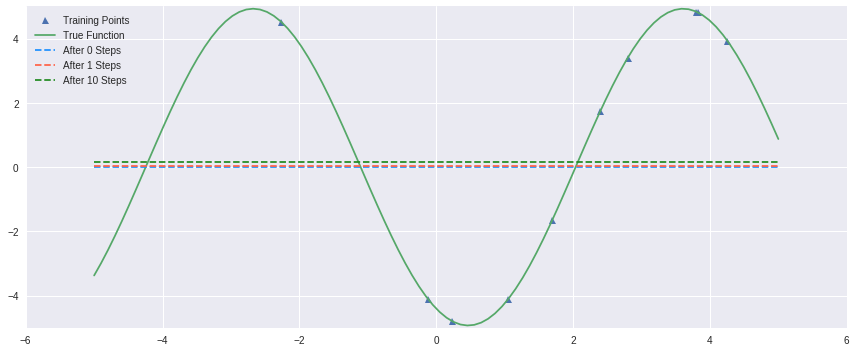

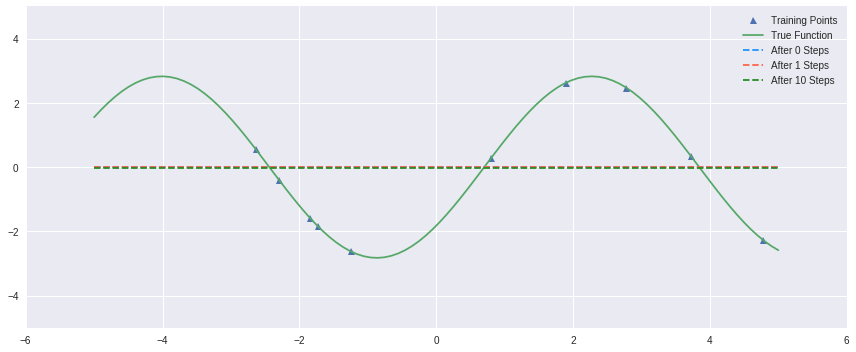

In [15]:
for index in np.random.choice(len(test_ds), size=3, replace=False):
    eval_sinewave_for_test(neural_net, test_ds[index])

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

In [0]:
def train_maml(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=1000):
    '''Train using the MAML setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = keras.optimizers.Adam()
    
    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.call(x)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x[0:5], y[0:5])
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x[5:], y[5:])
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            
            if i % log_steps == 0 and i >= 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

#### Training MAML

It should take around 40 seconds to train for 1000 steps.

Step 0: loss = 5.102571252470375, Time to run 1000 steps = 0.11163973808288574
Step 1000: loss = 3.901845964291778, Time to run 1000 steps = 42.23545598983765
Step 2000: loss = 3.926324881648962, Time to run 1000 steps = 42.29151105880737
Step 3000: loss = 3.9881947508498, Time to run 1000 steps = 41.66291165351868
Step 4000: loss = 3.9492954009823653, Time to run 1000 steps = 40.209805488586426
Step 5000: loss = 3.89363693817275, Time to run 1000 steps = 40.20694971084595
Step 6000: loss = 3.7429727052097297, Time to run 1000 steps = 39.89883279800415
Step 7000: loss = 3.55813717713478, Time to run 1000 steps = 42.08489513397217
Step 8000: loss = 3.392748776085739, Time to run 1000 steps = 43.48543953895569
Step 9000: loss = 3.2479507888778865, Time to run 1000 steps = 41.40713381767273
Step 10000: loss = 3.131235903124829, Time to run 1000 steps = 40.794018030166626
Step 11000: loss = 3.024445597385286, Time to run 1000 steps = 40.40769028663635
Step 12000: loss = 2.937365202588862, 

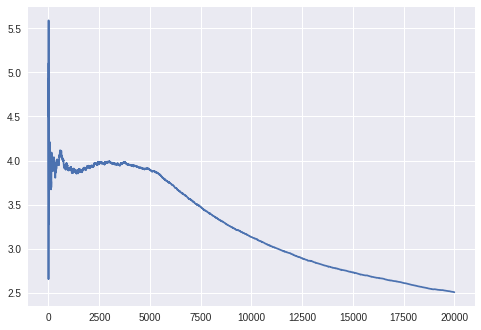

In [17]:
maml = SineModel()
train_maml(maml, 1, train_ds)

####  MAML model: compare average


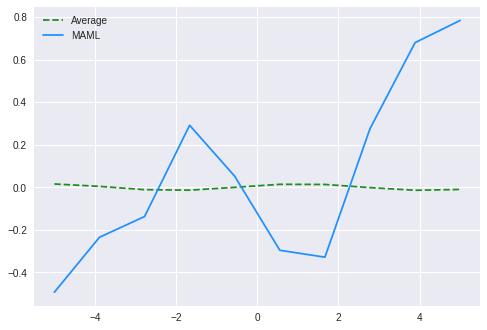

In [21]:
plot_model_comparison_to_average(maml, train_ds, model_name='MAML')

#### Use MAML model to fit new sine wave

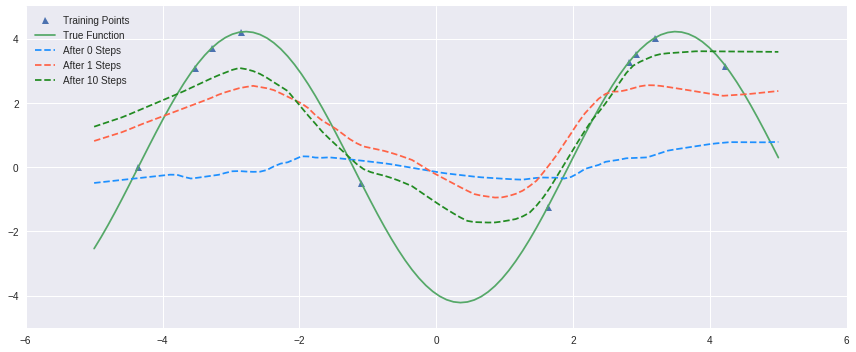

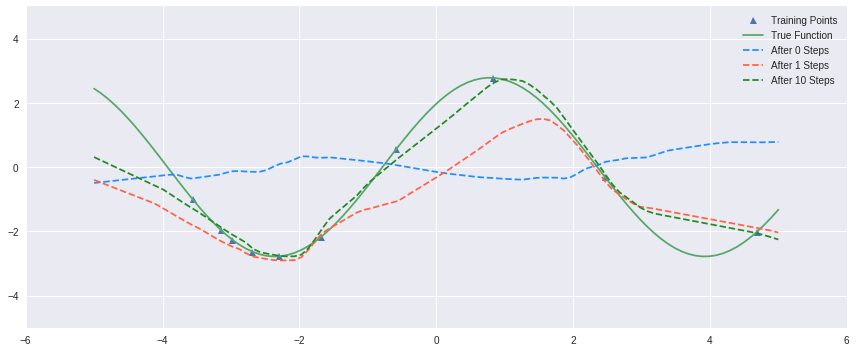

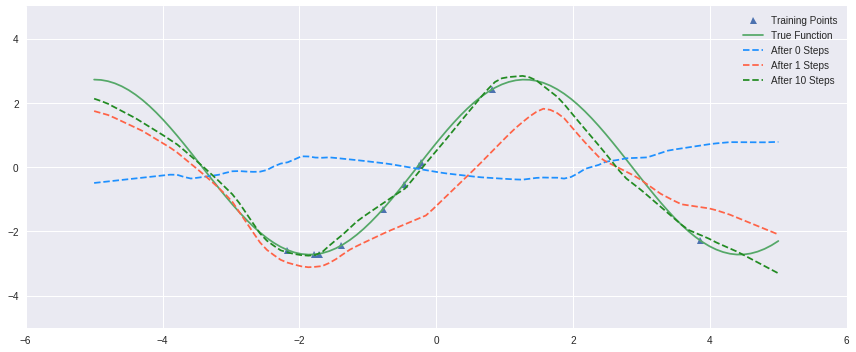

In [22]:
for index in np.random.choice(len(test_ds), size=3, replace=False):
    eval_sinewave_for_test(maml, test_ds[index])

### MAML vs Regular Neural Network

In [0]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.
    
    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    if intermediate_plot:
        print('MAML')
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot)
    if intermediate_plot:
        print('Neural Net')
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, plot=intermediate_plot)
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    legend = []
    fig = plt.figure(figsize=(12, 5), tight_layout=True)
    ax = fig.add_subplot(1,1,1)
    i = 0
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        ax.plot(x, y, marker=marker, linestyle=linestyle, color=colors[i])
        i+=1%3
        ax.set_xticks(num_steps)
        ax.set_ylabel('loss')
        legend.append(name)
    ax.legend(legend)
    plt.show()

MAML


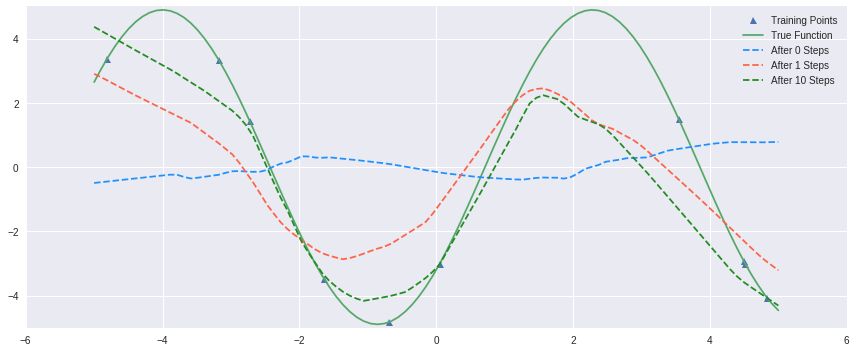

Neural Net


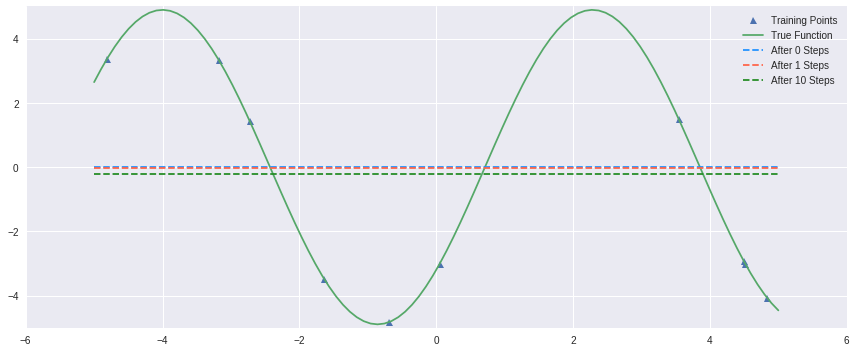

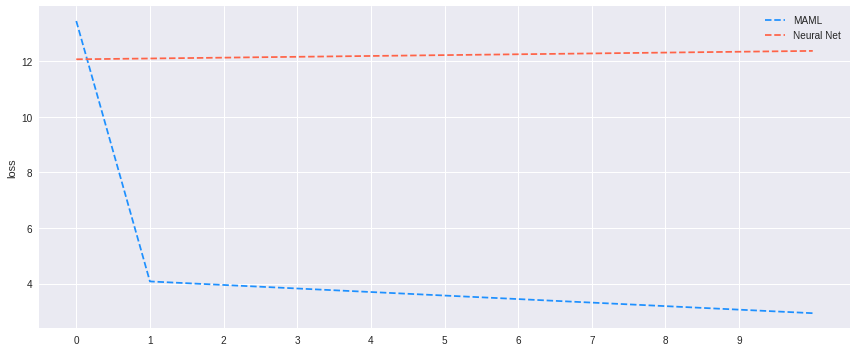

MAML


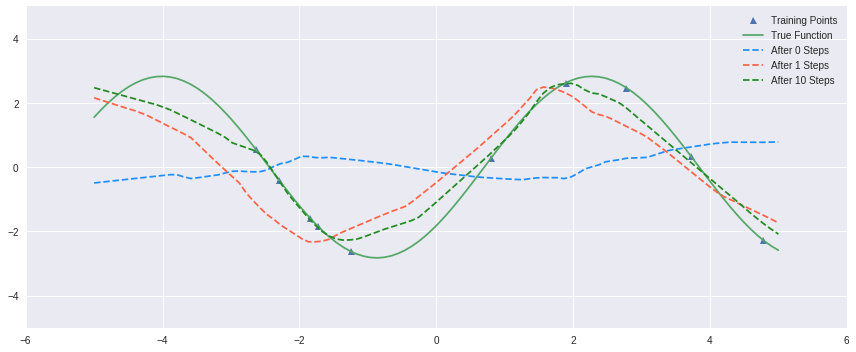

Neural Net


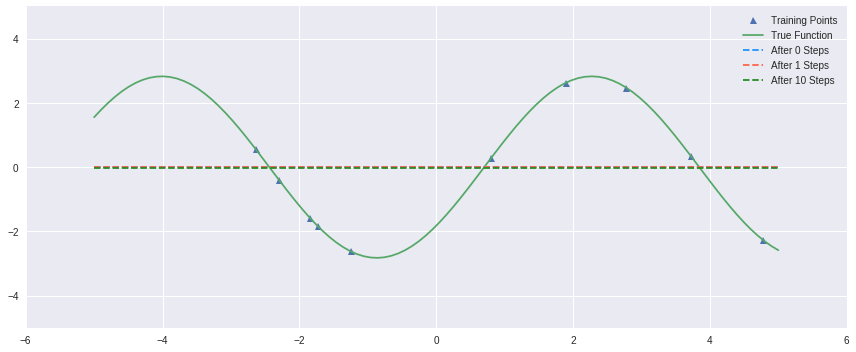

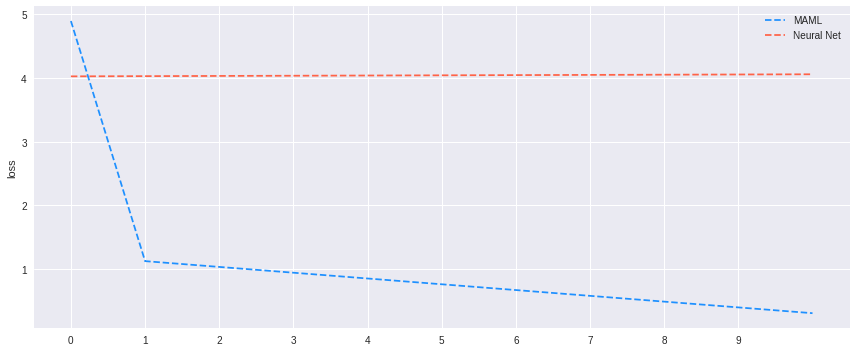

MAML


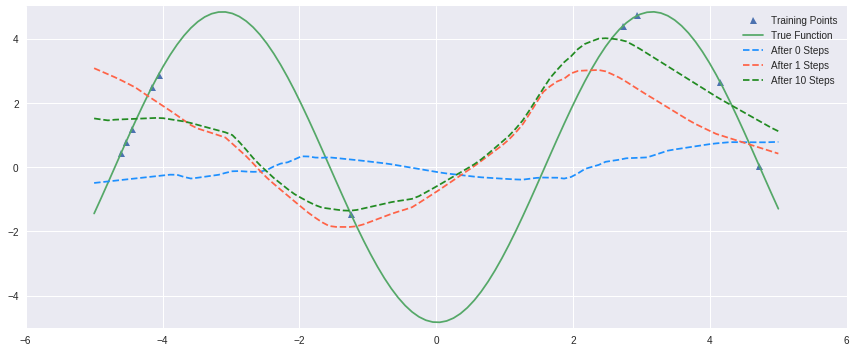

Neural Net


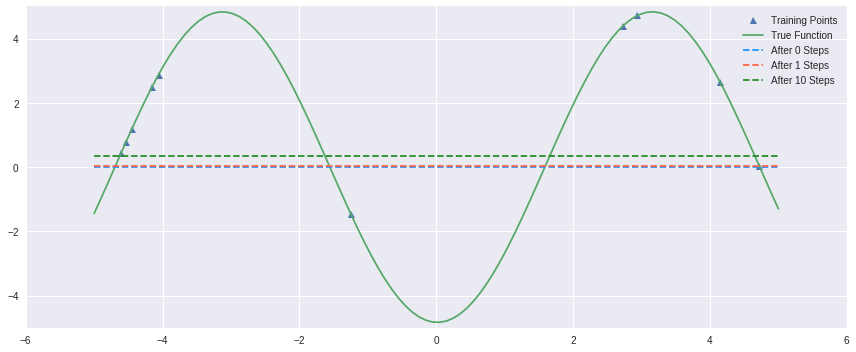

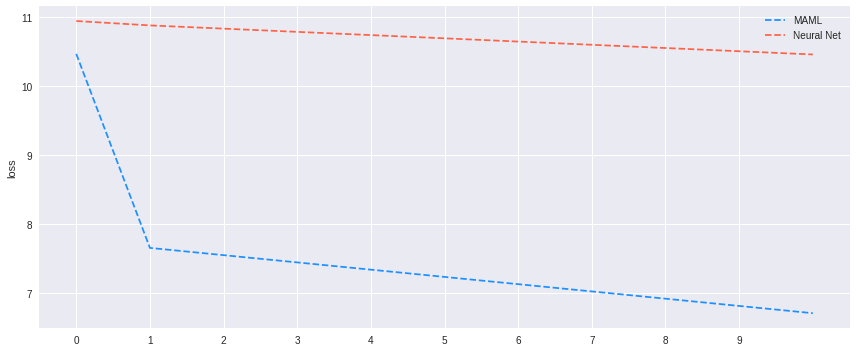

In [24]:
for _ in range(3):
    index = np.random.choice(range(len(test_ds)))
    compare_maml_and_neural_net(maml, neural_net, test_ds[index])

# Weights analysis

# Hidden_1

### regular net

[ 0.04448844  0.02749817  0.00218194  0.0222759   0.01548237  0.01952443
 -0.02110005  0.00880292  0.04765211 -0.01336224  0.02665538  0.00685563
  0.02169687  0.00603579  0.0031061   0.00713641  0.01592253  0.00878434
  0.02737682 -0.00115451 -0.03160259  0.03916527 -0.01546265  0.0183501
  0.02788157  0.01101007  0.01471737 -0.00855106 -0.00203964  0.00805976
  0.00421231 -0.03993115 -0.00779358  0.00381245  0.03885033 -0.00601686
  0.00655175  0.02827835  0.00646672 -0.00110445]
0.13311880790720926
n:
 [ 2.  0.  2.  4.  6. 10.  5.  7.  1.  3.] 
bin:
 [-0.03993115 -0.03117282 -0.0224145  -0.01365617 -0.00489785  0.00386048
  0.01261881  0.02137713  0.03013546  0.03889378  0.04765211]

 bin with most amount 0.0038604794979340204


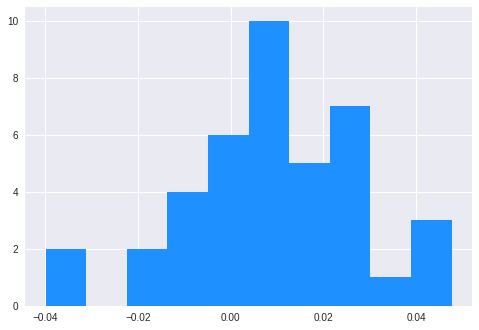

In [50]:
w1 = neural_net.hidden1.get_weights()[0][0]
print(w1)
print(tf.norm(w1).cpu().numpy())

data = plt.hist(w1, facecolor='dodgerblue')
n ,bin_ = data[0], data[1]
print('n:\n', n,'\nbin:\n', bin_)
print('\n bin with most amount', bin_[np.argmax(n)])

### MAML

[-0.13226643 -0.00186861  0.3108413   0.39698502  0.2152692   0.17362773
 -0.20410977 -0.12293386 -0.1374674   0.19581897 -0.20748868  0.27153264
 -0.21119742  0.04291514 -0.26046766  0.15137071  0.04068981 -0.27241784
  0.40465919  0.23967994  0.00924632 -0.22177427 -0.20292842  0.02529196
  0.00921501  0.00589409 -0.13234041  0.0037206   0.31566967 -0.04902343
 -0.02177416 -0.16753238  0.22532741 -0.22022372 -0.27031448  0.14877246
 -0.23560181  0.28658311 -0.18631915 -0.25504043]
1.2978706751990488
n:
 [9. 5. 3. 3. 7. 0. 4. 3. 4. 2.] 
bin:
 [-0.27241784 -0.20471014 -0.13700244 -0.06929473 -0.00158703  0.06612067
  0.13382838  0.20153608  0.26924378  0.33695149  0.40465919]

 bin with most amount -0.27241784210952846


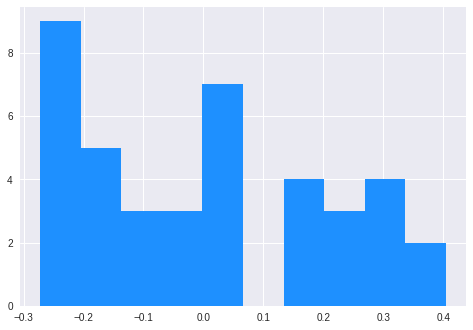

In [51]:
w1 = maml.hidden1.get_weights()[0][0]
print(w1)
print(tf.norm(w1).cpu().numpy())

data = plt.hist(w1, facecolor='dodgerblue')
n ,bin_ = data[0], data[1]
print('n:\n', n,'\nbin:\n', bin_)
print('\n bin with most amount', bin_[np.argmax(n)])

# Hidden_2

### regular net

In [54]:
w2 = neural_net.hidden2.get_weights()[0]
print(w2)
print(tf.norm(w2).cpu().numpy())

[[ 0.01050292  0.1084584  -0.13902364 ...  0.25450346  0.20163515
   0.01404925]
 [ 0.05629656 -0.17191476  0.16100609 ... -0.30772741  0.08482245
   0.02906019]
 [ 0.01751593  0.24114298 -0.27950551 ... -0.37051577  0.23182178
   0.08275952]
 ...
 [-0.20156917 -0.16805168  0.19001712 ...  0.00180697  0.16557359
   0.0437269 ]
 [-0.05106281 -0.15563473  0.19859535 ... -0.00515117  0.2057494
   0.17341732]
 [ 0.2081235  -0.00520841  0.24321045 ...  0.04528232  0.08644594
   0.10402451]]
6.702495073838733


[1.0156565247139486, 0.9868722923187997, 1.0562397263808332, 1.0186600242240866, 1.156414617811716, 0.9557836148757584, 0.9741878377573819, 0.9957226216971035, 0.9477624272133154, 1.1737510912600202, 1.0549820544071762, 1.1152192497309805, 1.1139761297768094, 1.1500553699110854, 0.8482478219468538, 1.22797528234097, 1.2502444321897943, 0.9121274510323278, 1.0309394979856663, 0.9885636547705082, 1.1087474667590775, 1.2688921115187601, 1.2506905823012933, 0.9133633810326821, 1.004223089392575, 0.9701044210547024, 1.1560575771423198, 1.1538419595466982, 1.03221004846987, 0.9460791398143907, 1.0648677321193039, 1.0783264764990217, 1.0188442947243008, 1.0505470056759552, 1.0527684535868318, 1.0077102238353715, 0.9809078944082027, 1.1273454152812916, 1.0797759191705225, 0.9682346924847193]
n:
 [1. 2. 6. 7. 8. 3. 4. 5. 0. 4.] 
bin:
 [0.84824782 0.89031225 0.93237668 0.97444111 1.01650554 1.05856997
 1.1006344  1.14269882 1.18476325 1.22682768 1.26889211]

 1.0165055377756163


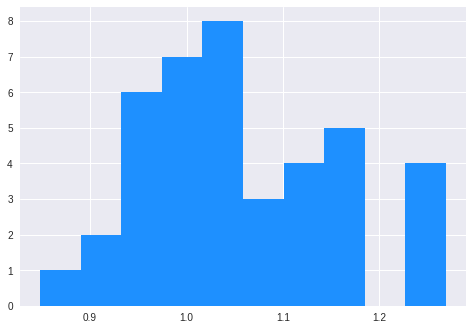

In [29]:
w_norm =[]
for w in neural_net.hidden2.get_weights()[0]:
  # print(w)
  w_norm.append(tf.norm(w).cpu().numpy())
print(w_norm)

data = plt.hist(w_norm, facecolor='dodgerblue')
n ,bin_ = data[0], data[1]
print('n:\n', n,'\nbin:\n', bin_)
print('\n', bin_[np.argmax(n)])

### MAML

In [78]:
w2 = maml.hidden2.get_weights()[0]
print(w2)
print(tf.norm(w2).cpu().numpy())
print(tf.norm(w2, axis=1).cpu().numpy())

[[ 0.05852086 -0.03152457  0.19006603 ...  0.00250187  0.05551319
   0.17647551]
 [ 0.19686744 -0.12124903  0.20188412 ...  0.73183327  0.06178124
  -0.35772547]
 [ 0.17703613  0.28219125 -0.01506798 ...  0.06070929 -0.68630376
   0.30188554]
 ...
 [ 0.06101048 -0.00159995 -0.30104482 ... -0.01013701 -0.37997223
   0.1534893 ]
 [ 0.04809721 -0.22032214  0.00615966 ... -0.57640426 -0.07918135
   0.17203165]
 [ 0.16003668 -0.08614174  0.15353505 ... -0.26074508 -0.12782959
   0.03485966]]
10.783155218226518
[1.46272335 3.01803748 1.66030054 1.66434131 1.34544833 1.55276642
 1.78368813 1.5394092  1.38125188 1.53246613 1.73386785 1.46347903
 1.54148157 1.44721275 1.56265072 1.53765255 2.08447371 1.17367323
 1.61448043 1.46016227 2.24026273 1.52226698 1.35938591 2.40395413
 2.75332106 1.01018502 1.48007321 0.97905616 1.77077544 2.57398764
 1.44222201 1.70311265 1.66010983 1.46800983 1.5143387  1.40085161
 1.60105346 1.4921244  1.56178633 1.65408457]


[1.4627233518186755, 3.0180374799734113, 1.6603005448627668, 1.6643413129606677, 1.3454483336665344, 1.552766424977357, 1.783688127137029, 1.5394092002564679, 1.3812518794556425, 1.5324661276696527, 1.7338678453299432, 1.4634790253731067, 1.5414815720622401, 1.447212752322197, 1.5626507196539383, 1.5376525471410003, 2.0844737141610374, 1.1736732320624026, 1.6144804336196952, 1.4601622736379736, 2.240262727838084, 1.5222669848370782, 1.3593859087628994, 2.403954132557024, 2.7533210569512123, 1.0101850188548225, 1.4800732128864404, 0.9790561581870117, 1.7707754441135215, 2.5739876438659466, 1.4422220140920792, 1.7031126497918216, 1.6601098280645115, 1.4680098286484895, 1.5143387000369388, 1.400851608706378, 1.6010534626768906, 1.4921243968044933, 1.5617863272059151, 1.6540845658236405]
n:
 [ 3.  3. 18. 10.  0.  1.  2.  1.  1.  1.] 
bin:
 [0.97905616 1.18295429 1.38685242 1.59075055 1.79464869 1.99854682
 2.20244495 2.40634308 2.61024122 2.81413935 3.01803748]

 1.3868524225442918


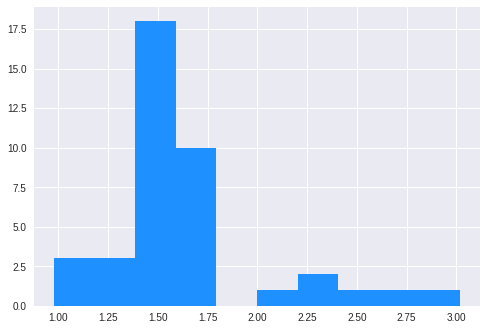

In [30]:
w_norm_maml =[]
for w in maml.hidden2.get_weights()[0]:
  # print(w)
  w_norm_maml.append(tf.norm(w).cpu().numpy())
print(w_norm_maml)
data = plt.hist(w_norm_maml, facecolor='dodgerblue')
n ,bin_ = data[0], data[1]
print('n:\n', n,'\nbin:\n', bin_)
print('\n', bin_[np.argmax(n)])

# last layer

### regular net

[[-1.70021091e-01]
 [-2.73751003e-01]
 [ 4.59936457e-02]
 [-3.11588793e-02]
 [ 5.05919079e-02]
 [ 1.36820796e-01]
 [-1.93606389e-01]
 [ 2.74508513e-03]
 [ 2.59308003e-02]
 [ 2.37072665e-02]
 [ 4.70726789e-02]
 [-3.91961624e-03]
 [-4.90719396e-04]
 [-2.71481748e-01]
 [ 7.16630378e-03]
 [ 8.64643273e-02]
 [ 4.32404290e-02]
 [-7.47634174e-04]
 [-5.74362426e-05]
 [ 3.09409315e-01]
 [-2.53841347e-01]
 [ 8.85113285e-06]
 [-1.40491918e-01]
 [-7.75519813e-03]
 [ 1.03908709e-01]
 [-4.37361685e-02]
 [-1.12283041e-01]
 [-6.21418753e-02]
 [ 5.51312264e-02]
 [-1.59367082e-02]
 [ 1.14231754e-01]
 [-1.09895596e-01]
 [ 1.27073437e-01]
 [-2.27052500e-01]
 [ 9.35436145e-02]
 [ 2.97143698e-01]
 [ 5.03209804e-02]
 [-1.41337396e-01]
 [ 2.73116270e-01]
 [ 1.55976721e-01]]
 norm: 0.8809145551556303
n:
 [ 4.  2.  4.  2. 10.  8.  5.  2.  0.  3.] 
bin:
 [-0.273751   -0.21543497 -0.15711894 -0.09880291 -0.04048688  0.01782916
  0.07614519  0.13446122  0.19277725  0.25109328  0.30940931]

 bin with most amount -0

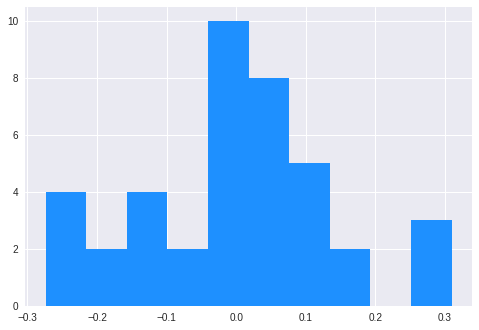

In [67]:
w3 = neural_net.out.get_weights()[0]
print(w3)
print(f' norm: {tf.norm(w3).cpu().numpy()}')

data = plt.hist(w3, facecolor='dodgerblue')
n ,bin_ = data[0], data[1]
print('n:\n', n,'\nbin:\n', bin_)
print('\n bin with most amount', bin_[np.argmax(n)])

### MAML

[[ 0.70600001]
 [-0.5840604 ]
 [ 0.12770207]
 [-0.37637563]
 [-0.05096032]
 [ 1.0787606 ]
 [ 0.06475126]
 [ 0.17690923]
 [-0.52276034]
 [ 0.65399481]
 [-0.73258254]
 [ 0.39451564]
 [ 0.63326094]
 [ 0.33135417]
 [-1.05372013]
 [-0.12508157]
 [-0.1663905 ]
 [-0.68400977]
 [ 0.84913436]
 [-0.47086738]
 [ 0.46472584]
 [-0.62099425]
 [-0.38623954]
 [ 1.08422136]
 [-0.13801032]
 [ 0.18012898]
 [ 0.50945754]
 [-0.13064426]
 [ 0.01542645]
 [-0.63301257]
 [-0.5412068 ]
 [-0.03626835]
 [-0.94836713]
 [-0.58207998]
 [ 0.31816244]
 [-0.87441225]
 [ 0.81712134]
 [-0.38359532]
 [ 0.32675688]
 [-0.24333158]]
norm: 3.564011907017927
n:
 [3. 3. 6. 4. 6. 5. 4. 4. 3. 2.] 
bin:
 [-1.05372013 -0.83992598 -0.62613183 -0.41233768 -0.19854353  0.01525062
  0.22904476  0.44283891  0.65663306  0.87042721  1.08422136]

 bin with most amount -0.6261318293880116


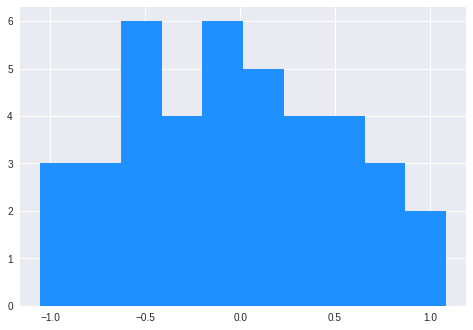

In [68]:
w3 = maml.out.get_weights()[0]
print(w3)
print(f'norm: {tf.norm(w3).cpu().numpy()}')
data = plt.hist(w3, facecolor='dodgerblue')
n ,bin_ = data[0], data[1]
print('n:\n', n,'\nbin:\n', bin_)
print('\n bin with most amount', bin_[np.argmax(n)])